<a href="https://colab.research.google.com/github/RLWH/reinforcement-learning-notebook/blob/master/3.%20Model%20Free%20Prediction/Ch7_TD(lambda)_n_step_Bootstrapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ch7 n-step bootstraping (TD($\lambda$))

TD(0) takes one step ahead of the reality to form state value estimation, how about taking more steps ahead? And, if we take infinity steps ahead, does it become MC methods instead?

The idea of *n-step TD methods* is to generalise both MC and TD methods so that one can shift from one to the other smoothly as needed. 

The *n-step* methods provides a spectrum with MC methods at one end and TD(0) at the other. The best methods are often intermediate between the two extremes.

The another advantage of n-step TD methods is it provides a timeframe for values to be updated. 
> With one-step TD methods, the same time step determines how often the action can be changed and the time interval over which bootstrapping is done. In many applications, one wants to be able to update the action very fast to take into account anything that has changed, but bootstrapping works best if it is over a length of time in which a significant and recognizable state change has occured

The idea of n-step methods is usually used as an introduction to the algorithmic idea of *eligibility traces* as well, which will be covered in the future.

In this notebook, we will only cover the prediction problem ot n-step bootstrapping methods.

## The formulation of n-step TD prediction

Consider estimating $v_{\pi}$ from sample episodes generated using $\pi$. 
- Monte Carlo methods perform an update for each state based on the entire sequence of observed rewards from that state until the end of the episode
- One-step TD(0) is based on just the one next reward, bootstraping from the value of the state one step later as a proxy for the remaining rewards.
- And between these two extremes, there are a lot of intermediate methods would perform an update based on an itermediate number of rewards: More than one but less than all of them until termination

![Diagram](https://raw.githubusercontent.com/RLWH/reinforcement-learning-notebook/master/images/NStepTD_new.png)

### Formal definition of n-step TD methods

Formally, consider the update of the estimated value of state $S_t$ as a result of the state-reward sequence of a MRP, $S_t, R_{t+1}, S_{t+1}, R_{t+2}, ..., R_T, S_T$. 

#### Monte Carlo updates
For Monte carlo updates the estimate of $v_{\pi}(S_t)$, it depends on the complete return:
\begin{equation}
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... + \gamma ^{T-t-1}R_T
\end{equation}
where $T$ is the last time step of the episode. Let's call this quantity the *target* of the update.

#### From one-step return to n-step return
\begin{equation}
G^{(1)}_{t} = R_{t+1} + \gamma V_t(S_{t+1})
\end{equation}
where $V_t$  here is the value estimate at time t of $v_{\pi}$. This is same as TD(0).
\begin{equation}
G^{(2)}_{t} = R_{t+1} + \gamma R_{t+2} + \gamma^2 V_{t+1}(S_{t+2})
\end{equation}
where now $\gamma^2 V{t+1}(S_{t+2})$ corrects for the absence of the terms $\gamma^2 R_{t+3} + \gamma^3 R_{t+4} + ... + \gamma^{T-t-1}R_T$

...

Thus, similarly, we can formulate a n-step return as
\begin{equation}
G^{(n)}_{t} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1}R_{t+n} + \gamma^n V_{t+n-1}(S_{t+n})
\end{equation}
for all n, t such that $n \geq 1$  and $0 \leq t \lt T-n$

#### How to calculate the n-step return?
It would be impractical to calculate the n-step return at time step t for $n > 1$ as it involves future rewards, and it will not be available during the time of transition from $t$ to $t+1$. Thus, we will use a n-step TD algorithm to approach the problem.

\begin{equation}
V_{t+n}(S_t) = V_{t+n-1}(S_t) + \alpha [G^{(n)}_{t} - V_{t+n-1}(S_t)]
\end{equation}
for $0 \leq t \lt T$

### Generic N-step temporal-difference learning
\begin{equation}
V_{\text{new}}(S_t) \leftarrow V_{\text{old}}(S_t) + \alpha (G^{n}_{t} - V_{\text{}old}(S_t))
\end{equation}

## Random walk example with n-step TD methods

Consider the same Random walk example as in Ch6

![Random Walk Diagram](https://github.com/RLWH/reinforcement-learning-notebook/blob/master/images/RandomWalk.PNG?raw=true)

## Task
Now, we extend the task to 19 states instead of 5, and use n-step TD methods 

In this case, so how can we know which $n$ is better?

In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
NUM_STATES = 19
END_STATES = [0, NUM_STATES + 1]

In [0]:
# Setup the true values
TRUE_VALUE = np.arange(-20, 22, 2) / 20.0
TRUE_VALUE[0] = TRUE_VALUE[-1] = 0

In [0]:
START_STATE = 10

In [25]:
print(TRUE_VALUE)

[ 0.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  0. ]


In [0]:
GAMMA = 1

In [0]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

In [0]:
def random_walk_action(s):
  """
  Return an action for the random walk game
  """
  
  if np.random.binomial(1, 0.5) == 1:
    ns = s + 1
  else:
    ns = s - 1
    
  return ns

In [0]:
def reward_mapping(ns, left_reward=0, right_reward=1):
  """
  Return reward given next state
  """
  if ns == 0:
    reward = left_reward
  elif ns == (NUM_STATES + 1):
    reward = right_reward
  else:
    reward = 0
    
  return reward

In [30]:
print(reward_mapping(0, left_reward=-1))

-1


In [31]:
np.arange(0, 20)[1:2]

array([1])

In [0]:
values = np.zeros(NUM_STATES + 2)

In [0]:
def n_step_temporal_difference(values, n, alpha):
  """
  N-step TD algorithm
  
  We know that in MC updates, the estimate of v_pi(S_t) is updated in the
  direction of the complete return:
  G_t = R_t+1 + gamma R_t+2 + gamma ^ 2 R_t+3 + ... + gamma ^ (T - t - 1)R_T
  
  e.g. G_0
  G_0 = R_1 + gamma R_2 + gamma ^ 2 R_3 + ... + gamma ^ (T - 1) R_T
  
  One-step return
  One-step udpates the target is the first reward plus the discounted estimated
  value of the next state
  G_t(1) = R_t+1 + gamma V(S_t+1)
  
  e.g. 
  G_0(1) = R_1 + gamma v(S_1)
  
  n-step return
  G_t(2) = R_t+1 + gamma R_t+2 + gamma ^ 2 V(S_t+2)
  
  e.g. 
  G_0(2) = R_1 + gamma R_2 + gamma ^ 2 V(S_2)
  G_0(3) = R_1 + gamma R_2 + gamma ^ 2 R_3 + gamma ^ 3 V(S_3)
  ...
  G_0(n) = R_1 + gamma R_2 + gamma ^ 2 R_3 + gamma^(n-1) + gamma ^ n V(S_n)
  
  Note that this approach is inspired but different from Shangtong's solution
  A vectorized approach is used for computing the discounted returns
  
  Args:
    values: The values of all states, a vector with size S
    n: The number of step ahead
    alpha: discount factor
  """
  
  # First run the whole sequence
  state = 10
  
  # Arrays to store states and rewards for an episode
  states = [state]
  rewards = [0]
  
  # Track the time
  t = 0
  
  # Length of the episode
  T = float('inf')
  
  while True:
    
    if t < T:
      
      # Take an action according to the policy
      next_state = random_walk_action(state)
      reward = reward_mapping(next_state, left_reward=-1, right_reward=1)
#       print(reward)
      
      # Observe and store the next reward as R_t+1 and the next state as S_t+1
      states.append(next_state)
      rewards.append(reward)
      
      # If S_t+1 is terminal, then T = t + 1
      if next_state in END_STATES:
        T = t + 1
      
    # Setup the update time
    # tau is the time whose state's estimate is being updated
    # For n-step TD, update is only available if the sequence is longer than n
    # Thus, the first time available is at t + n
    tau = t - n + 1
    
    if tau >= 0:
      # n-step update is available
      returns = 0.0
#       print(rewards)
      select_rewards = np.array(rewards[tau + 1: min(tau + n + 1, T + 1)]).T
#       print(select_rewards)
      gammas = \
        np.power(GAMMA, 
                 [i - tau - 1 
                  for i in range(tau + 1, min(tau + 1 + n, T + 1))])
      
      returns = np.dot(gammas, select_rewards)
      
      if tau + n < T:
        returns += pow(GAMMA, n) * values[states[tau + n]]
      
      # Update new state value by using old value function
#       print("len(states) -> ", len(states))
#       print("tau ->", tau)
#       print("states ->", states)
#       print("states[tau] ->", states[tau])

      if not states[tau] in END_STATES:
        values[states[tau]] = values[states[tau]] + alpha * (returns - values[states[tau]])
      
    if tau == (T - 1):
      break
      
    state = next_state
    
    # Increase one timestep
    t += 1
    
#   print(states)

In [35]:
for i in range(20):
  n_step_temporal_difference(values, 1, 1)
  print(values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
[ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  0.]
[ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  1.  0.]
[ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  1.  1.  0.]
[ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.
  1.  1.  0.]
[ 0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  0.]
[ 0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.
  1.  1.  0.]
[ 0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  0.]
[ 0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.
  1.  1.  0.]
[ 0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.]
[ 0. -1. -1.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  0.]


In [0]:
%matplotlib inline

In [0]:
# Figure 7.2, it will take quite a while
def figure7_2():
    # all possible steps
    steps = np.power(2, np.arange(0, 10))

    # all possible alphas
    alphas = np.arange(0, 1.1, 0.1)

    # each run has 10 episodes
    episodes = 10

    # perform 100 independent runs
    runs = 100

    # track the errors for each (step, alpha) combination
    errors = np.zeros((len(steps), len(alphas)))
    
    for run in range(0, runs):
        for step_ind, step in zip(range(len(steps)), steps):
            for alpha_ind, alpha in zip(range(len(alphas)), alphas):
              
#                 print('run:', run, 'step:', step, 'alpha:', alpha)
                value = np.zeros(NUM_STATES + 2)
#                 print(len(value))
                
                for ep in range(0, episodes):
#                     print(value)
                    n_step_temporal_difference(value, step, alpha)
                    # calculate the RMS error
#                     print(value)
                    errors[step_ind, alpha_ind] += np.sqrt(np.sum(np.power(value - TRUE_VALUE, 2)) / NUM_STATES)
    # take average
    errors /= episodes * runs

    for i in range(0, len(steps)):
        plt.plot(alphas, errors[i, :], label='n = %d' % (steps[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.ylim([0.25, 0.55])
    plt.legend()
    plt.show()
#     plt.savefig('../images/figure_7_2.png')
#     plt.close()


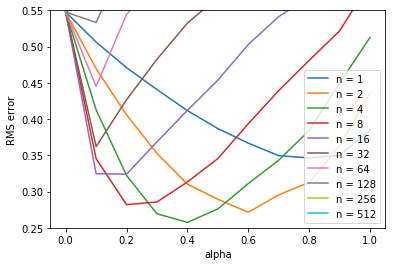

CPU times: user 6min 55s, sys: 1.34 s, total: 6min 56s
Wall time: 6min 54s


In [43]:
%%time
figure7_2()

In [0]:
# all states
N_STATES = 19

# discount
GAMMA = 1

# all states but terminal states
STATES = np.arange(1, N_STATES + 1)

# start from the middle state
START_STATE = 10

# two terminal states
# an action leading to the left terminal state has reward -1
# an action leading to the right terminal state has reward 1
END_STATES = [0, N_STATES + 1]

# true state value from bellman equation
TRUE_VALUE = np.arange(-20, 22, 2) / 20.0
TRUE_VALUE[0] = TRUE_VALUE[-1] = 0

# n-steps TD method
# @value: values for each state, will be updated
# @n: # of steps
# @alpha: # step size
def temporal_difference(value, n, alpha):
    # initial starting state
    state = START_STATE

    # arrays to store states and rewards for an episode
    # space isn't a major consideration, so I didn't use the mod trick
    states = [state]
    rewards = [0]

    # track the time
    time = 0

    # the length of this episode
    T = float('inf')
    while True:
        # go to next time step
        time += 1

        if time < T:
            # choose an action randomly
            if np.random.binomial(1, 0.5) == 1:
                next_state = state + 1
            else:
                next_state = state - 1

            if next_state == 0:
                reward = -1
            elif next_state == 20:
                reward = 1
            else:
                reward = 0

            # store new state and new reward
            states.append(next_state)
            rewards.append(reward)

            if next_state in END_STATES:
                T = time

        # get the time of the state to update
        update_time = time - n
        if update_time >= 0:
            returns = 0.0
            # calculate corresponding rewards
            for t in range(update_time + 1, min(T, update_time + n) + 1):
                returns += pow(GAMMA, t - update_time - 1) * rewards[t]
            # add state value to the return
            if update_time + n <= T:
                returns += pow(GAMMA, n) * value[states[(update_time + n)]]
            state_to_update = states[update_time]
            # update the state value
            if not state_to_update in END_STATES:
                value[state_to_update] += alpha * (returns - value[state_to_update])
        if update_time == T - 1:
            break
        state = next_state

# Figure 7.2, it will take quite a while
def figure7_2_orig():
    # all possible steps
    steps = np.power(2, np.arange(0, 10))

    # all possible alphas
    alphas = np.arange(0, 1.1, 0.1)

    # each run has 10 episodes
    episodes = 10

    # perform 100 independent runs
    runs = 100

    # track the errors for each (step, alpha) combination
    errors = np.zeros((len(steps), len(alphas)))
    for run in range(0, runs):
        for step_ind, step in zip(range(len(steps)), steps):
            for alpha_ind, alpha in zip(range(len(alphas)), alphas):
                # print('run:', run, 'step:', step, 'alpha:', alpha)
                value = np.zeros(N_STATES + 2)
                for ep in range(0, episodes):
                    temporal_difference(value, step, alpha)
                    # calculate the RMS error
                    errors[step_ind, alpha_ind] += np.sqrt(np.sum(np.power(value - TRUE_VALUE, 2)) / N_STATES)
    # take average
    errors /= episodes * runs

    for i in range(0, len(steps)):
        plt.plot(alphas, errors[i, :], label='n = %d' % (steps[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.ylim([0.25, 0.55])
    plt.legend()

    plt.show()

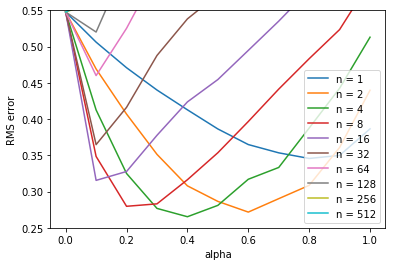

In [48]:
figure7_2_orig()

## The $\lambda$-return and the Eligibility Traces - From MC, n-step TD to TD($\lambda$)

#### The $\lambda$-return

The idea of the $\lambda$-return is that we can come up with a better approximation by averaging differentn-step returns. For example, we can average a $G{(2)}$ and $G^{(4)}$ return and give

\begin{equation}
\frac{1}{2}G^{(2)} + \frac{1}{2}G^{(4)}
\end{equation}

If we extend the idea, we can combine information from all time-steps, or even, in principle, one could even average experience-based updates with DP updates to get a simple combination of experience-based and model-based methods. The question is: How can we efficiently combine them?

The TD($\lambda$) algorithm can be understood as one particular way of compounding n-step updates. This average contains all the n-step updates, and each weighted proportionally to $\lambda^{n-1}$, where $\lambda \in [0, 1]$, and is normalized by a factor of ($1-\lambda$) to ensure the weighted sum is 1. (Recall sum of G.S.). The resulting update is tward a return, called the *$\lambda$-return*, wne defined in its state-based form by 
\begin{equation}
G^{\lambda}_t = (1 - \lambda)\sum_{n=1}^{\infty}\lambda ^ {n-1} G^{(n)}_{t}
\end{equation}

If the MDP terminates at timestep T, we can formulate TD($\lambda$) return as
\begin{equation}
G^{\lambda}_{t} = (1-\lambda)\sum^{T-t-1}_{n=1} \lambda^{n-1} G^{(n)}_{t} + \lambda ^ {T-t-1}G_t
\end{equation}

This fomulation has 2 important properties:
1. If $\lambda = 1$ => The main sum goes to zero, and thus the $\lambda$-return is a Monte Carlo algorithm
2. If $\lambda = 0$ => The remaining term is $G^{(1)}_t$, which is the one-step TD update

The formualtion can be presented in the backup diagram as below. 
![TD Backup](https://raw.githubusercontent.com/RLWH/reinforcement-learning-notebook/master/images/TD_lambda_backup.png)

i.e. The $\lambda$-return $G^{\lambda}_t$ combines all n-step returns by using weight $(1-\lambda)\lambda^{n-1}$

![Fig 12.2](https://raw.githubusercontent.com/RLWH/reinforcement-learning-notebook/master/images/lambda_return_decay.png)








### Forward-view TD($\lambda$)

Theoretically, the forward view TD($\lambda$) does the same trick as what we used to do:
\begin{equation}
V(S_t) \leftarrow V(S_t) + \alpha {(G^{\lambda}_t - V(S_t))}
\end{equation}

![Figure 12.4](https://raw.githubusercontent.com/RLWH/reinforcement-learning-notebook/master/images/forward_TD.png)

The properties of the Forward-view TD($\lambda$) is
1. It updates value function towards the $\lambda$-return
2. Forward-view looks into the future to compute G^{\lambda}_t
3. Like MC, it can be computed from complete episodes

So, how can we solve the forward looking problem? -> *Eligibility Traces*

### Eligibility Traces
Denote a variable $E_t$ is the eligibility traces at time $t$:

In TD($\lambda$), the eligibility trace $E_t \in \mathop{\mathbb{R}}^d$ is a short-term memory vector that looks back what has happened, and combine both *Frequency heuristic* and *Recency heuristic*. 

Note: 
- Frequency heuristic: Assign credit to most frequent states
- Recency heuristic: assign credit to most recent states

#### Formulation
\begin{equation}
\begin{split}
E_0(s) &= 0 \\
E_t(s) &= \gamma \lambda E_{t-1}(s) + \mathop{\mathbb{1}}(S_t = s)
\end{split}
\end{equation}

The idea is we can initialise an empty eligibility trace at time step 0.

For each time step, we discount the value of the previous eligibility trace by $\gamma$ and $\lambda$ and increase the eligibility trace by 1 for each visit.

### Backward-view TD($\lambda$)
The backward, or mechanistic view of TD($\lambda$). Each update depends on the current TD error combined with the current eligibility traces of past events. 

![Figure 12.5](https://raw.githubusercontent.com/RLWH/reinforcement-learning-notebook/master/images/backward_TD.png)

Steps:
1. Keep an eligibility trace for every state $s$
2. Update value $V(s)$ for every state $s$
3. In proportion to TD-error $\delta_t$ and eligibility trace $E_t(s)$

whereas
\begin{equation}
\begin{split}
\delta_t &= R_{t+1} + \gamma V(S_{t+1}) - V(S_t) \\
V(s) &\leftarrow V(s) + \alpha \delta_t E_t(s)
\end{split}
\end{equation}

### The algorithm
So, from the equations, we now know
1. when $\lambda = 0$, only current state is updated
\begin{equation}
\begin{split}
E_t(s) &= \mathop{\mathbb(S_t = s)} \\
V(s) & \leftarrow V(s) + \alpha \delta_t E_t(s)
\end{split}
\end{equation}
which becomes the TD(0) update
\begin{equation}
V(s_t) \leftarrow V(s_t) + \alpha \delta_t
\end{equation}
 
2. When $\lambda = 1$, credit is deferred until end of episode. Thus, the total update of TD(1) is the same as total update for MC
 
    For $\lambda = 1$ and where $s$ is visited once at time step $k$
\begin{equation}
\begin{split}
E_t(s) & = \gamma E_{t-1}(s) + \mathop{\mathbb{1}}(S_t = s)\\
& = 
\begin{cases}
0, & \text{if } t \lt k \\
\gamma^{t-k} & \text{if } t \geq k
\end{cases}
\end{split}
\end{equation}

#### Pseudo code
---
```
Input: the policy pi to be evaluated
Input: value mapping function
Algorithm parameters: step size alpha > 0, trace decay rate lambda in [0, 1]

Loop for each episode:
    Initialise S
    eligibility_trace = 0 for all states
    Loop for each step of episode:
        Choose A in policy pi(s)
        Take action A, observe R_t+1, S_t+1
        eligibility_trace = gamma * eligibility_trace + one(state_t = t)
        delta = R + gamma * value(s_t+1) - value(s)
        s = s_t+1
        
      until s_t+1 is terminal

```
---
